In [19]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=41f72a6823f8da4fa4f711e81b86c39eef48615c7791d7427f68664c1829a9df
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [20]:

import tarfile
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
import wandb
import torch.nn as nn
import scipy.io
import numpy as np

In [ ]:
torch.manual_seed(247)

In [ ]:
wandb.login()

In [ ]:
wandb.init(project="CV_A1_Q2", entity="iiitd")

In [2]:
trans = tt.Compose([
    tt.ToTensor(),tt.Resize((224,224)),tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
    
])



In [3]:
train_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
download_url(train_url, '.')

  0%|          | 0/182040794 [00:00<?, ?it/s]

In [4]:
class DataSet:
  def __init__(self,path,transform = None):
    self.raw = scipy.io.loadmat(path)
    self.X = self.raw['X'].transpose()
    self.y = self.raw['y']
    self.transform = transform
  
  def __getitem__(self,index):
    img = np.transpose(self.X[index], (1, 2, 0))
    #print(img.shape)
    if self.transform is not None:
        img = self.transform (img)
    label = self.y[index]
    if label[0] ==10:
      label = [0]
    return img , label[0]

  def __len__(self):
    return self.y.shape[0]


In [5]:
#data = torchvision.datasets.SVHN('.',download=True,transform=trans)

train_path = r'/content/train_32x32.mat'
#test_path = r'/content/test_32x32.mat'
data = DataSet(train_path,trans)
#test = DataSet(test_path,trans)

In [ ]:
data[4][1]

In [6]:
test_size = int(len(data)*0.1)
val_size = int(len(data)*0.2)
train_size = len(data)-test_size-val_size

train_ds, val_ds ,test_ds = random_split(data, [train_size,val_size, test_size])

print(len(train_ds), len(val_ds),len(test_ds))

51281 14651 7325


In [7]:
batch =32

In [8]:
train_dl = DataLoader(train_ds, batch, shuffle=True)
val_dl = DataLoader(val_ds, batch, shuffle=True)
test_dl = DataLoader(test_ds, batch, shuffle=True)

In [9]:
from collections import Counter
train_class={i:0 for i in range(0,10)}
for _, label in train_dl:
  for j in label:
    train_class[j.item()]+=1



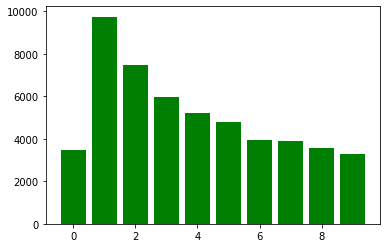

In [10]:
plt.bar(list(train_class.keys()), train_class.values(), color='g')
plt.show()

In [11]:

test_class={i:0 for i in range(10)}
for _, label in test_dl:
  for j in label:
    test_class[j.item()]+=1



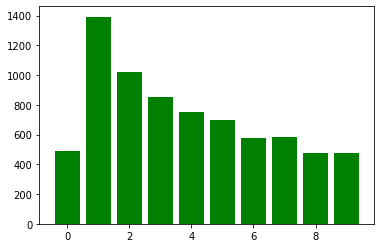

In [12]:
plt.bar(list(test_class.keys()), test_class.values(), color='g')
plt.show()

In [13]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, label in dl:
        print(images[0].shape)
        print(label[:64])
        show_images(images, nmax)
        break

torch.Size([3, 224, 224])
tensor([3, 1, 4, 3, 3, 4, 3, 6, 3, 7, 0, 8, 3, 1, 5, 9, 1, 6, 1, 1, 1, 1, 6, 6,
        2, 4, 5, 2, 0, 9, 2, 1])


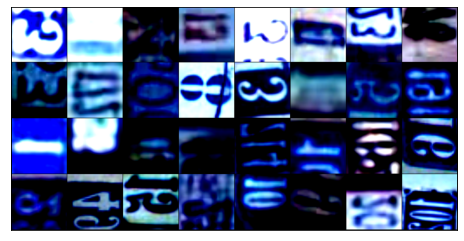

In [14]:
show_batch(train_dl,64)

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == (labels)).item() / len(preds))


class Model(nn.Module):
  def __init__(self ):
    super().__init__()
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(in_features=512,out_features=10)
    self.network =model
  def forward(self, x):
    return self.network(x)
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred,label)
      return loss
  
  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred, label)  
      acc = accuracy(pred, label)
      return {'acc':acc , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]}, accuracy: {result["valid_acc"]}')

In [17]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs):
  history = []
  optimizer =  optim(model.parameters(),lr=lr)
  
  for epoch in range(epochs):
    train_loss = []
    model.train()
    for batch in tqdm(train_dl):
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      train_loss.append(loss.item())
      optimizer.step()
      
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

In [ ]:

cmodel = Model()

cmodel = to_device(cmodel,'cuda')
lr = 0.008
optimizer= torch.optim.Adam
epochs=10
wandb.config = {'lr':lr,'optimuzer':'Adam','epochs':epochs,'batch_size':batch}

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
wandb.watch(cmodel)
from tqdm.notebook import tqdm
history=fit(train_dl,val_dl,cmodel,lr,optimizer,epochs)

  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :1, training loss: 2.2694548841424087, validation loss: 2.232722682203268, accuracy: 0.19248847663402557


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :2, training loss: 1.162678849358746, validation loss: 0.3607134052499413, accuracy: 0.8917344212532043


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :3, training loss: 0.3176090393810349, validation loss: 0.3051313566060241, accuracy: 0.9092395305633545


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :4, training loss: 0.25072135013851776, validation loss: 0.2929885338902408, accuracy: 0.9144251346588135


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :5, training loss: 0.20957385142045054, validation loss: 0.2761198513466035, accuracy: 0.9239774942398071


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :6, training loss: 0.17524682116710436, validation loss: 0.22327818250177858, accuracy: 0.9386472702026367


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :7, training loss: 0.14637552705754342, validation loss: 0.21841356627933892, accuracy: 0.9389758110046387


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :8, training loss: 0.11967528313520369, validation loss: 0.24537896493543346, accuracy: 0.934063196182251


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :9, training loss: 0.09537713105902303, validation loss: 0.2668250489743085, accuracy: 0.9348263144493103


  0%|          | 0/1603 [00:00<?, ?it/s]

epoch :10, training loss: 0.07711869633518155, validation loss: 0.28056986529694505, accuracy: 0.9370096921920776


In [ ]:
# run = wandb.init(entity="iiitd",name="meta_data",project="CV_A1_Q2",id='0wwo9uox', resume="must",settings=wandb.Settings(start_method="thread"))


# artifact = run.use_artifact('iiitd/CV_A1_Q2/model:v0', type='model')
# artifact_dir = artifact.download()

# cmodel = to_device(Model(),'cuda')
# state_dict = torch.load( artifact_dir +'/model.pth')
# cmodel.load_state_dict(state_dict)

In [ ]:
from sklearn.metrics import f1_score,accuracy_score

test_dl = DeviceDataLoader(test_dl,'cuda')
@torch.no_grad()
def test_accuracy_f1(test_dl):
  cmodel.eval()
  acc=0
  f1=0
  list_label = []
  list_pred = []
  

  for num,(img,label) in enumerate(test_dl):
    outputs = cmodel(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().tolist(),label.cpu().clone().tolist())
    
    list_label+=labelx
    list_pred+=predx
  f1 =f1_score(list_label,list_pred,average='macro')
  acc =accuracy_score(list_label,list_pred)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                       y_true=list_label, preds=list_pred,
                     )})
  wandb.log({'f1_score':f1,'accuracy_score':acc})
  return f'f1 Score: {f1}', f'Accuracy: {acc}'
score_rate = test_accuracy_f1(test_dl)
print(score_rate)



('f1 Score: 0.9318428151389705', 'Accuracy: 0.9358361774744027')


In [ ]:
torch.save(cmodel.state_dict(),"model.pth")
artifact  = wandb.Artifact('model',type = 'model')
artifact.add_file('model.pth')
wandb.log_artifact(artifact)

In [ ]:
wandb.finish()

accuracy,▁█████████
accuracy_score,▁
epoch,▁▂▃▃▄▅▆▆▇█
f1_score,▁
training loss,█▄▂▂▁▁▁▁▁▁
validation loss,█▁▁▁▁▁▁▁▁▁
accuracy,0.93701
accuracy_score,0.93584
epoch,10
f1_score,0.93184
training loss,0.07712


In [21]:
run = wandb.init(entity="iiitd",name="meta_data",project="CV_A1_Q2",id='w0m7pix9', resume="must",settings=wandb.Settings(start_method="thread"))


artifact = run.use_artifact('iiitd/CV_A1_Q2/model:v0', type='model')
artifact_dir = artifact.download()

cmodel = Model()
state_dict = torch.load( artifact_dir +'/model.pth')
cmodel.load_state_dict(state_dict)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb:   1 of 1 files downloaded.  
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

get_graph_node_names(cmodel)

(['x',
  'network.conv1',
  'network.bn1',
  'network.relu',
  'network.maxpool',
  'network.layer1.0.conv1',
  'network.layer1.0.bn1',
  'network.layer1.0.relu',
  'network.layer1.0.conv2',
  'network.layer1.0.bn2',
  'network.layer1.0.add',
  'network.layer1.0.relu_1',
  'network.layer1.1.conv1',
  'network.layer1.1.bn1',
  'network.layer1.1.relu',
  'network.layer1.1.conv2',
  'network.layer1.1.bn2',
  'network.layer1.1.add',
  'network.layer1.1.relu_1',
  'network.layer2.0.conv1',
  'network.layer2.0.bn1',
  'network.layer2.0.relu',
  'network.layer2.0.conv2',
  'network.layer2.0.bn2',
  'network.layer2.0.downsample.0',
  'network.layer2.0.downsample.1',
  'network.layer2.0.add',
  'network.layer2.0.relu_1',
  'network.layer2.1.conv1',
  'network.layer2.1.bn1',
  'network.layer2.1.relu',
  'network.layer2.1.conv2',
  'network.layer2.1.bn2',
  'network.layer2.1.add',
  'network.layer2.1.relu_1',
  'network.layer3.0.conv1',
  'network.layer3.0.bn1',
  'network.layer3.0.relu',
  'netw

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


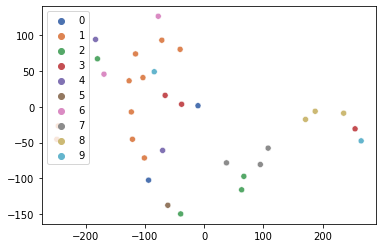

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
test_dl = DeviceDataLoader(test_dl,'cpu')
for i,j in test_dl:
  X = (create_feature_extractor(to_device(cmodel,'cpu'),{"network.layer4.1.conv2":'network.layer4.1.conv2'})(i)['network.layer4.1.conv2']).detach().numpy()
  X = X.reshape(batch,-1)
  X_embedded = TSNE(n_components=2, learning_rate='auto',init='pca', perplexity=3).fit_transform(X)
    
  x1= []
  y1 = []
  for i in X_embedded:
    x1.append(i[0])
    y1.append(i[1])

  sns.scatterplot(x1,y1,hue=j,palette="deep")
  break

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


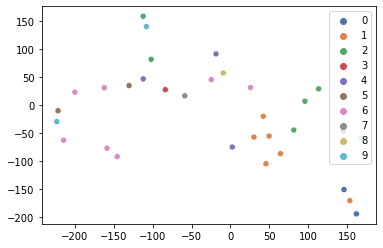

In [ ]:

dl = DeviceDataLoader(train_dl,'cpu')
for i,j in dl:
  X = (create_feature_extractor(to_device(cmodel,'cpu'),{"network.layer4.1.conv2":'network.layer4.1.conv2'})(i)['network.layer4.1.conv2']).detach().numpy()
  X = X.reshape(batch,-1)
  X_embedded = TSNE(n_components=2, learning_rate='auto',init='pca', perplexity=3).fit_transform(X)
  x1= []
  y1 = []
  for i in X_embedded:
    x1.append(i[0])
    y1.append(i[1])

  sns.scatterplot(x1,y1,hue=j,palette="deep")
  break

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


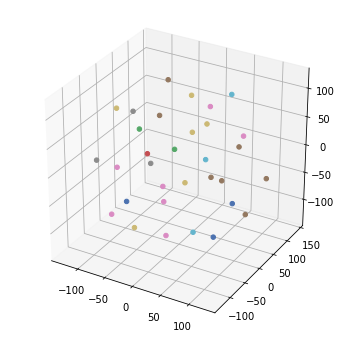

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("deep", 256).as_hex())


dl = DeviceDataLoader(val_dl,'cpu')
for i,j in dl:
  X = (create_feature_extractor(to_device(cmodel,'cpu'),{"network.layer4.1.conv2":'network.layer4.1.conv2'})(i)['network.layer4.1.conv2']).detach().numpy()
  X = X.reshape(batch,-1)
  X_embedded = TSNE(n_components=3, learning_rate='auto').fit_transform(X)
  x1= []
  y1 = []
  z1 = []
  l = []
  for ii in X_embedded:
    x1.append(ii[0])
    y1.append(ii[1])
    z1.append(ii[2])
  for jj in j.numpy():
      l.append(jj)

  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111, projection = '3d')
  #ax = Axes3D(fig, auto_add_to_figure=False)
  

  ax.scatter(x1,y1,z1,c=j,cmap=cmap, alpha=1,label=l)#,palette="deep")
  #ax.legend(handles=l)
  #sns.scatterplot(x1,y1,hue=j,palette="deep")
  break

In [ ]:
run = wandb.init(entity="iiitd",name="meta_data",project="CV_A1_Q2",id='w0m7pix9', resume="must",settings=wandb.Settings(start_method="thread"))


artifact = run.use_artifact('iiitd/CV_A1_Q2/model:v0', type='model')
artifact_dir = artifact.download()

cmodel = Model()
state_dict = torch.load( artifact_dir +'/model.pth',map_location=torch.device('cpu'))
cmodel.load_state_dict(state_dict)

accuracy,0.93701
accuracy_score,0.93584
epoch,10
f1_score,0.93184
training loss,0.07712
validation loss,0.28057


wandb:   1 of 1 files downloaded.  


<All keys matched successfully>

In [23]:
from torchvision.models.feature_extraction import create_feature_extractor

feature_vect = [[] for i in range(10)]
misscs = [[] for i in range(10)]

for i,j in test_dl:
  X = (create_feature_extractor(cmodel,{'network.flatten':'network.flatten'})(i)['network.flatten']).detach().numpy()


  for z in range(len(i)):
    pred = torch.argmax(cmodel(i[z].unsqueeze (0)),dim=1)
    label = j[z]
    if pred.item() != label.item():
      misscs[j[z]].append((  X[z],pred  ))
    else:
      feature_vect[j[z]].append(X[z])

In [25]:
centroid = [ [] for i in range(10)]
for i in range(10):
  centroid[i].append(np.nanmean(feature_vect[i],axis=0))

<ipython-input-25-c570c227827e>:3: RuntimeWarning: Mean of empty slice
  centroid[i].append(np.nanmean(feature_vect[i],axis=0))


In [34]:
for i in range(len(centroid)):
  if np.isnan(centroid[i]).any():
    centroid[i]=[0]
    

In [36]:

for sel,j in enumerate(misscs):
  for i in range(3):
    print(f'original class  --- {sel}',f' predicted class --{j[i][1].item()}')
    print(np.linalg.norm(j[i][0] - centroid[sel][0]))
    


original class  --- 0  predicted class --2
7.8685336
original class  --- 0  predicted class --2
4.3798385
original class  --- 0  predicted class --2
10.433564
original class  --- 1  predicted class --2
3.5417166
original class  --- 1  predicted class --2
4.07713
original class  --- 1  predicted class --2
4.267862
original class  --- 2  predicted class --3
4.6842523
original class  --- 2  predicted class --3
6.2900414
original class  --- 2  predicted class --1
3.8741415
original class  --- 3  predicted class --1
3.7105315
original class  --- 3  predicted class --2
5.2546897
original class  --- 3  predicted class --2
3.7616057
original class  --- 4  predicted class --2
5.3331285
original class  --- 4  predicted class --2
6.3792844
original class  --- 4  predicted class --3
7.7030034
original class  --- 5  predicted class --2
7.8810287
original class  --- 5  predicted class --3
10.524517
original class  --- 5  predicted class --2
7.267393
original class  --- 6  predicted class --3
6.02839